In [2]:
!pip install segmentation-models-pytorch

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import InterpolationMode
from scipy.ndimage import binary_erosion, distance_transform_edt
import segmentation_models_pytorch as smp
from tqdm import tqdm

import os
save_dir = "/content/drive/MyDrive/SHBT261/Project2"
os.makedirs(save_dir, exist_ok=True)

In [5]:
# Define the 21 classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print("Number of classes:", NUM_CLASSES)
print("Classes:", VOC_CLASSES)

# Class mapping dictionary
class_mapping = {i: cls for i, cls in enumerate(VOC_CLASSES)}

print("Pascal VOC 2007 Class Mapping:")
for idx, name in class_mapping.items():
    print(f"{idx:2d} → {name}")

PERSON_ID = 15  # person class id

Number of classes: 21
Classes: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Pascal VOC 2007 Class Mapping:
 0 → background
 1 → aeroplane
 2 → bicycle
 3 → bird
 4 → boat
 5 → bottle
 6 → bus
 7 → car
 8 → cat
 9 → chair
10 → cow
11 → diningtable
12 → dog
13 → horse
14 → motorbike
15 → person
16 → pottedplant
17 → sheep
18 → sofa
19 → train
20 → tvmonitor


In [ ]:
# Define transforms for the images
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),           # resize for speed
    # # ---------------------------------------
    # # Data Augmentation
    # # ---------------------------------------
    # transforms.ColorJitter(
    #     brightness=0.3,
    #     contrast=0.3,
    #     saturation=0.3,
    #     hue=0.02
    # ),
    # transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),                   # convert to tensor (C,H,W)
])

transform_target = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    # transforms.Resize((256, 256)),           # resize mask too
    transforms.PILToTensor()                 # keep as tensor (H,W)
])

# Load the Pascal VOC 2007 Segmentation Dataset
train_dataset = VOCSegmentation(
    root="/content/drive/MyDrive/SHBT261/Project2/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

val_dataset = VOCSegmentation(
    root="/content/drive/MyDrive/SHBT261/Project2/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Train samples: 209
Validation samples: 213


In [32]:
# Create DataLoaders
train_size = int(0.8 * len(train_dataset))
train_val_size = len(train_dataset) - train_size

train_set, train_val_set = random_split(train_dataset, [train_size, train_val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
train_val_loader = DataLoader(train_val_set, batch_size=4, shuffle=False, num_workers=2)

test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


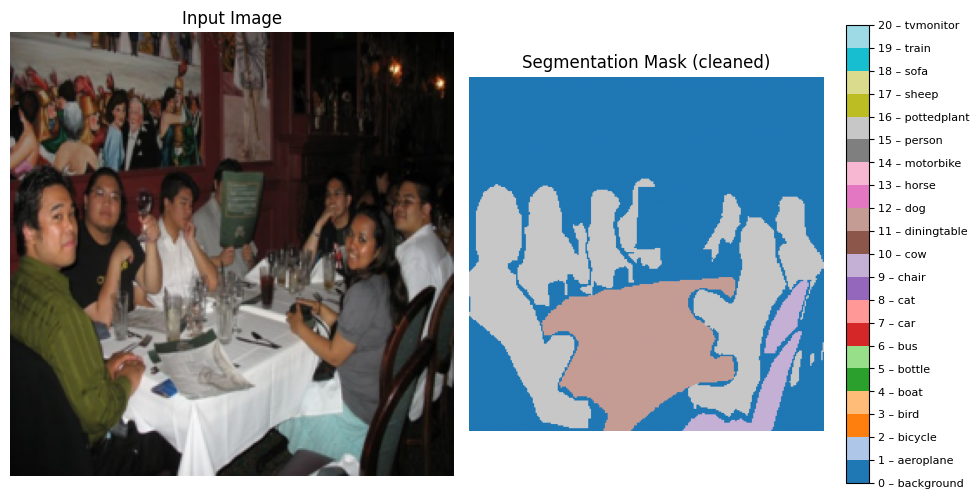

Classes in this mask: [  0   9  11  15 255]


In [ ]:
# Visualize one image and mask
def show_sample(img, mask):
    img = img.permute(1, 2, 0).numpy()      # C,H,W -> H,W,C
    mask = mask.squeeze().numpy().copy()    # 1,H,W -> H,W

    mask_vis = mask.copy()
    mask_vis[mask_vis > 20] = 0

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    seg_map = plt.imshow(mask_vis, cmap="tab20", vmin=0, vmax=20)
    plt.title("Segmentation Mask (cleaned)")
    plt.axis("off")

    cbar = plt.colorbar(seg_map, ticks=range(21))
    tick_labels = [f"{i} – {VOC_CLASSES[i]}" for i in range(21)]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()

images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)    # (B, 3, 256, 256)
print("Mask batch shape:", masks.shape)      # (B, 1, 256, 256)
show_sample(images[0], masks[0])
print("Classes in this mask:", np.unique(masks[0].numpy()))

### Model

In [8]:
# U-Net Model Definition

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1: coming from previous layer (upsampled), x2: skip connection
        x1 = self.up(x1)
        # padding if necessary (in case of odd dims)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final 1x1 conv to get logits for each class"""
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, num_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

In [9]:
IGNORE_INDEX = 255

def update_confusion_matrix(conf_mat, preds, targets, num_classes, ignore_index=IGNORE_INDEX):
    with torch.no_grad():
        valid_mask = (targets != ignore_index)
        preds = preds[valid_mask]
        targets = targets[valid_mask]
        if preds.numel() == 0:
            return

        k = (targets * num_classes + preds).long()
        bins = torch.bincount(k, minlength=num_classes * num_classes)
        conf = bins.reshape(num_classes, num_classes)
        conf_mat += conf.to(conf_mat.device)

def compute_metrics_from_confusion(conf_mat: np.ndarray):
    C = conf_mat.shape[0]
    conf = conf_mat.astype(np.float64)

    TP = np.diag(conf)
    FP = conf.sum(axis=0) - TP
    FN = conf.sum(axis=1) - TP

    # IoU per class
    denom_iou = TP + FP + FN
    per_class_iou = np.zeros(C, dtype=np.float64)
    per_class_iou[denom_iou > 0] = TP[denom_iou > 0] / denom_iou[denom_iou > 0]

    # Dice per class
    denom_dice = 2 * TP + FP + FN
    per_class_dice = np.zeros(C, dtype=np.float64)
    per_class_dice[denom_dice > 0] = 2 * TP[denom_dice > 0] / denom_dice[denom_dice > 0]

    # Per-class accuracy
    gt_per_class = conf.sum(axis=1)
    per_class_acc = np.zeros(C, dtype=np.float64)
    per_class_acc[gt_per_class > 0] = TP[gt_per_class > 0] / gt_per_class[gt_per_class > 0]

    # Pixel accuracy
    pixel_acc = TP.sum() / conf.sum() if conf.sum() > 0 else 0.0

    # Mean metrics (only over classes with GT pixels)
    valid_classes = gt_per_class > 0
    mean_iou = per_class_iou[valid_classes].mean() if valid_classes.any() else 0.0
    mean_dice = per_class_dice[valid_classes].mean() if valid_classes.any() else 0.0

    return {
        "pixel_acc": float(pixel_acc),
        "mean_iou": float(mean_iou),
        "mean_dice": float(mean_dice),
        "per_class_iou": per_class_iou,
        "per_class_acc": per_class_acc,
        "per_class_dice": per_class_dice,
    }

def hd95_binary(pred_mask: np.ndarray, true_mask: np.ndarray) -> float:
    pred = pred_mask.astype(bool)
    true = true_mask.astype(bool)

    if not pred.any() and not true.any():
        return 0.0
    if not pred.any() or not true.any():
        return 255.0

    structure = np.ones((3, 3), dtype=bool)
    true_erode = binary_erosion(true, structure=structure, border_value=0)
    pred_erode = binary_erosion(pred, structure=structure, border_value=0)

    true_surface = true ^ true_erode
    pred_surface = pred ^ pred_erode

    dt_true = distance_transform_edt(~true)
    dt_pred = distance_transform_edt(~pred)

    dist_true_to_pred = dt_pred[true_surface]
    dist_pred_to_true = dt_true[pred_surface]

    all_dist = np.concatenate([dist_true_to_pred, dist_pred_to_true])
    hd95 = np.percentile(all_dist, 95)

    return float(hd95)

In [ ]:
# ---------------------------------------
# Stable Multi-class Soft Dice Loss
# ---------------------------------------
class DiceLoss(nn.Module):
    def __init__(self, num_classes=21, ignore_index=255, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        B, C, H, W = probs.shape

        valid = (targets != self.ignore_index)
        targets_clean = targets.clone()
        targets_clean[~valid] = 0  # dummy class

        # (B,H,W,C) -> (B,C,H,W)
        targets_onehot = F.one_hot(targets_clean, C).permute(0,3,1,2).float()

        probs = probs * valid.unsqueeze(1)
        targets_onehot = targets_onehot * valid.unsqueeze(1)

        # flatten
        probs_flat   = probs.reshape(B, C, -1)
        targets_flat = targets_onehot.reshape(B, C, -1)

        intersection = (probs_flat * targets_flat).sum(-1)
        union = probs_flat.sum(-1) + targets_flat.sum(-1)

        dice = (2 * intersection + self.smooth) / (union + self.smooth)

        # remove background
        dice_fg = dice[:, 1:]

        # keep only GT-present classes
        exist_mask = (targets_flat[:, 1:].sum(-1) > 0)
        dice_fg = dice_fg[exist_mask]

        if dice_fg.numel() == 0:
            return torch.tensor(0.0, device=logits.device)

        return 1 - dice_fg.mean()

### Training

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()  # (B,1,H,W)->(B,H,W)

        optimizer.zero_grad()
        outputs = model(images)  # (B,C,H,W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        bs = images.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

    return running_loss / n_samples

def evaluate(model, loader, criterion, device, num_classes):
    model.eval()
    val_loss = 0.0
    n_samples = 0
    conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.long)

    hd95_list = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            outputs = model(images)  # (B,C,H,W)
            loss = criterion(outputs, masks)

            bs = images.size(0)
            val_loss += loss.item() * bs
            n_samples += bs

            preds = outputs.argmax(dim=1)  # (B,H,W)

            update_confusion_matrix(
                conf_mat,
                preds.view(-1).cpu(),
                masks.view(-1).cpu(),
                num_classes=num_classes,
                ignore_index=IGNORE_INDEX
            )

            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()

            for i in range(bs):
                gt = masks_np[i]
                pr = preds_np[i]

                # ignore void=255；frontground = (label != 0 且 != 255)
                gt_fg = (gt != 0) & (gt != IGNORE_INDEX)
                pr_fg = (pr != 0)

                if not gt_fg.any() and not pr_fg.any():
                    continue

                hd = hd95_binary(pr_fg, gt_fg)
                hd95_list.append(hd)

    avg_loss = val_loss / n_samples
    metrics = compute_metrics_from_confusion(conf_mat.cpu().numpy())
    mean_hd95 = float(np.mean(hd95_list)) if len(hd95_list) > 0 else float("nan")

    metrics["val_loss"] = avg_loss
    metrics["hd95"] = mean_hd95
    metrics["conf_mat"] = conf_mat.cpu().numpy()

    return metrics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(num_classes=NUM_CLASSES).to(device)

criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
criterion_dice = DiceLoss(num_classes=NUM_CLASSES)

def criterion(pred, target):
    ce   = criterion_ce(pred, target)
    dice = criterion_dice(pred, target)
    return ce + 0.02 * dice

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

Using device: cpu


In [ ]:
num_epochs = 30
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_unet_baseline.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = " (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

Epoch [1/30] | Train Loss: 2.9022 | Val Loss: 2.4619 | Val mIoU: 0.0387 | Val mDice: 0.0518 | Time: 5.7s 🌟 (best so far, model saved)
Epoch [2/30] | Train Loss: 2.5427 | Val Loss: 2.4148 | Val mIoU: 0.0375 | Val mDice: 0.0545 | Time: 4.9s 
Epoch [3/30] | Train Loss: 2.3813 | Val Loss: 2.0637 | Val mIoU: 0.0452 | Val mDice: 0.0602 | Time: 4.9s 🌟 (best so far, model saved)
Epoch [4/30] | Train Loss: 2.2301 | Val Loss: 2.2359 | Val mIoU: 0.0349 | Val mDice: 0.0493 | Time: 4.9s 
Epoch [5/30] | Train Loss: 2.1079 | Val Loss: 1.7009 | Val mIoU: 0.0464 | Val mDice: 0.0594 | Time: 5.6s 🌟 (best so far, model saved)
Epoch [6/30] | Train Loss: 2.0286 | Val Loss: 2.2801 | Val mIoU: 0.0350 | Val mDice: 0.0491 | Time: 5.0s 
Epoch [7/30] | Train Loss: 1.9566 | Val Loss: 1.9237 | Val mIoU: 0.0380 | Val mDice: 0.0515 | Time: 4.8s 
Epoch [8/30] | Train Loss: 1.8598 | Val Loss: 1.8854 | Val mIoU: 0.0411 | Val mDice: 0.0543 | Time: 5.5s 
Epoch [9/30] | Train Loss: 1.7800 | Val Loss: 1.9067 | Val mIoU: 0.0

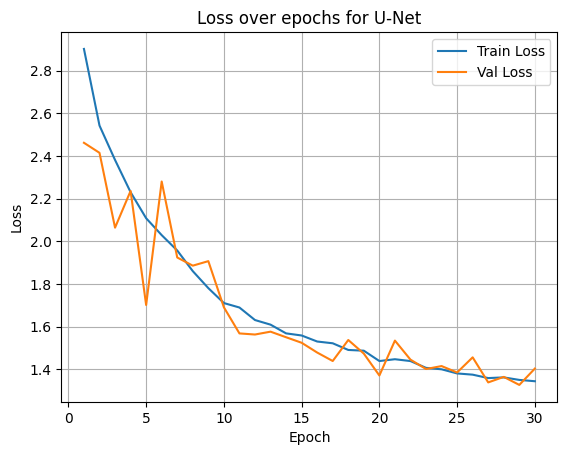

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for U-Net")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_unet_test.png")
plt.show()

### Test

In [ ]:
best_model = UNet(num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n U-Net Baseline Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )



 U-Net Baseline Results:
Val Loss       : 1.3910
Pixel Accuracy : 0.6771
Mean IoU       : 0.0426
Mean Dice      : 0.0533
Mean HD95      : 73.1726

Per-class IoU and Accuracy:
 0 background   | IoU: 0.7379 | Acc: 0.8625
 1 aeroplane    | IoU: 0.0000 | Acc: 0.0000
 2 bicycle      | IoU: 0.0000 | Acc: 0.0000
 3 bird         | IoU: 0.0000 | Acc: 0.0000
 4 boat         | IoU: 0.0000 | Acc: 0.0000
 5 bottle       | IoU: 0.0000 | Acc: 0.0000
 6 bus          | IoU: 0.0000 | Acc: 0.0000
 7 car          | IoU: 0.0000 | Acc: 0.0000
 8 cat          | IoU: 0.0000 | Acc: 0.0000
 9 chair        | IoU: 0.0000 | Acc: 0.0000
10 cow          | IoU: 0.0000 | Acc: 0.0000
11 diningtable  | IoU: 0.0000 | Acc: 0.0000
12 dog          | IoU: 0.0000 | Acc: 0.0000
13 horse        | IoU: 0.0000 | Acc: 0.0000
14 motorbike    | IoU: 0.0000 | Acc: 0.0000
15 person       | IoU: 0.1568 | Acc: 0.6794
16 pottedplant  | IoU: 0.0000 | Acc: 0.0000
17 sheep        | IoU: 0.0000 | Acc: 0.0000
18 sofa         | IoU: 0.0000 | 

### Ablation 1: UNet + Data Augmentation

In [ ]:
num_epochs = 30
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_unet_aug.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = " (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

Epoch [1/30] | Train Loss: 2.7919 | Val Loss: 2.5543 | Val mIoU: 0.0412 | Val mDice: 0.0558 | Time: 5.1s 🌟 (best so far, model saved)
Epoch [2/30] | Train Loss: 2.4192 | Val Loss: 2.5518 | Val mIoU: 0.0478 | Val mDice: 0.0671 | Time: 5.1s 🌟 (best so far, model saved)
Epoch [3/30] | Train Loss: 2.2795 | Val Loss: 2.6049 | Val mIoU: 0.0420 | Val mDice: 0.0585 | Time: 5.1s 
Epoch [4/30] | Train Loss: 2.1482 | Val Loss: 2.4637 | Val mIoU: 0.0506 | Val mDice: 0.0725 | Time: 5.1s 🌟 (best so far, model saved)
Epoch [5/30] | Train Loss: 2.0431 | Val Loss: 2.2396 | Val mIoU: 0.0522 | Val mDice: 0.0717 | Time: 5.9s 🌟 (best so far, model saved)
Epoch [6/30] | Train Loss: 1.9557 | Val Loss: 2.5370 | Val mIoU: 0.0512 | Val mDice: 0.0697 | Time: 5.0s 
Epoch [7/30] | Train Loss: 1.8698 | Val Loss: 2.1220 | Val mIoU: 0.0514 | Val mDice: 0.0697 | Time: 5.0s 
Epoch [8/30] | Train Loss: 1.7989 | Val Loss: 2.8570 | Val mIoU: 0.0554 | Val mDice: 0.0775 | Time: 5.9s 🌟 (best so far, model saved)
Epoch [9/30]

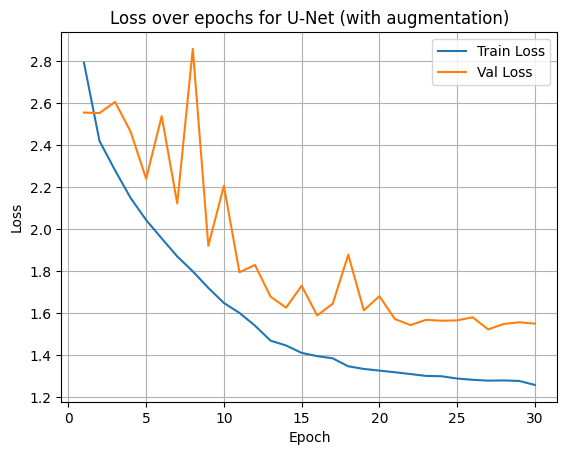

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for U-Net (with augmentation)")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_unet_aug.png")
plt.show()

In [ ]:
best_model = UNet(num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n U-Net (with augmentation) Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )


 U-Net (with augmentation) Results:
Val Loss       : 2.5560
Pixel Accuracy : 0.6394
Mean IoU       : 0.0405
Mean Dice      : 0.0521
Mean HD95      : 85.6220

Per-class IoU and Accuracy:
 0 background   | IoU: 0.6999 | Acc: 0.8222
 1 aeroplane    | IoU: 0.0000 | Acc: 0.0000
 2 bicycle      | IoU: 0.0000 | Acc: 0.0000
 3 bird         | IoU: 0.0000 | Acc: 0.0000
 4 boat         | IoU: 0.0000 | Acc: 0.0000
 5 bottle       | IoU: 0.0178 | Acc: 0.0726
 6 bus          | IoU: 0.0086 | Acc: 0.0162
 7 car          | IoU: 0.0000 | Acc: 0.0000
 8 cat          | IoU: 0.0000 | Acc: 0.0000
 9 chair        | IoU: 0.0000 | Acc: 0.0000
10 cow          | IoU: 0.0000 | Acc: 0.0000
11 diningtable  | IoU: 0.0000 | Acc: 0.0000
12 dog          | IoU: 0.0000 | Acc: 0.0000
13 horse        | IoU: 0.0000 | Acc: 0.0000
14 motorbike    | IoU: 0.0004 | Acc: 0.0004
15 person       | IoU: 0.1227 | Acc: 0.5355
16 pottedplant  | IoU: 0.0000 | Acc: 0.0000
17 sheep        | IoU: 0.0000 | Acc: 0.0000
18 sofa         | IoU

#### segmentation map

In [20]:
def pick_one_person_sample(dataset):
    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        mask_np = mask.squeeze().numpy()
        if PERSON_ID in np.unique(mask_np):
            return idx
    return None

sample_idx = pick_one_person_sample(val_dataset)
print("Chosen sample index:", sample_idx)

img, mask = val_dataset[sample_idx]

Chosen sample index: 4


In [25]:
def predict_mask(model, img_tensor):
    model.eval()
    with torch.no_grad():
        x = img_tensor.unsqueeze(0)
        out = model(x)
        pred = out.argmax(1).squeeze(0).cpu().numpy()
    return pred

In [ ]:
def show_img_gt_pred_aug(img, mask, pred_base, pred_aug):
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy().copy()
    pred_base_np = pred_base.copy()
    pred_aug_np = pred_aug.copy()

    # clean ignore index (=255)
    mask_np[mask_np > 20] = 0
    pred_base_np[pred_base_np > 20] = 0
    pred_aug_np[pred_aug_np > 20] = 0

    plt.figure(figsize=(14, 10))

    # 1. Input image
    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    # 2. Ground truth
    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # 3. Baseline UNet
    plt.subplot(1, 4, 3)
    plt.imshow(pred_base_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("UNet Baseline Prediction")
    plt.axis("off")

    # 4. Augmented UNet
    plt.subplot(1, 4, 4)
    plt.imshow(pred_aug_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("UNet Augmented Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/unet_map_base_aug.png")
    plt.show()

In [ ]:
# Baseline UNet
unet_baseline = UNet(num_classes=NUM_CLASSES)
unet_baseline.load_state_dict(torch.load(f"{save_dir}/best_unet_baseline.pth", map_location=device))
unet_baseline.eval()

# Augmented UNet
unet_aug = UNet(num_classes=NUM_CLASSES).to(device)
unet_aug.load_state_dict(torch.load(f"{save_dir}/best_unet_aug.pth", map_location=device))
unet_aug.eval()

print("✓ Both models loaded!")


✓ Both models loaded!


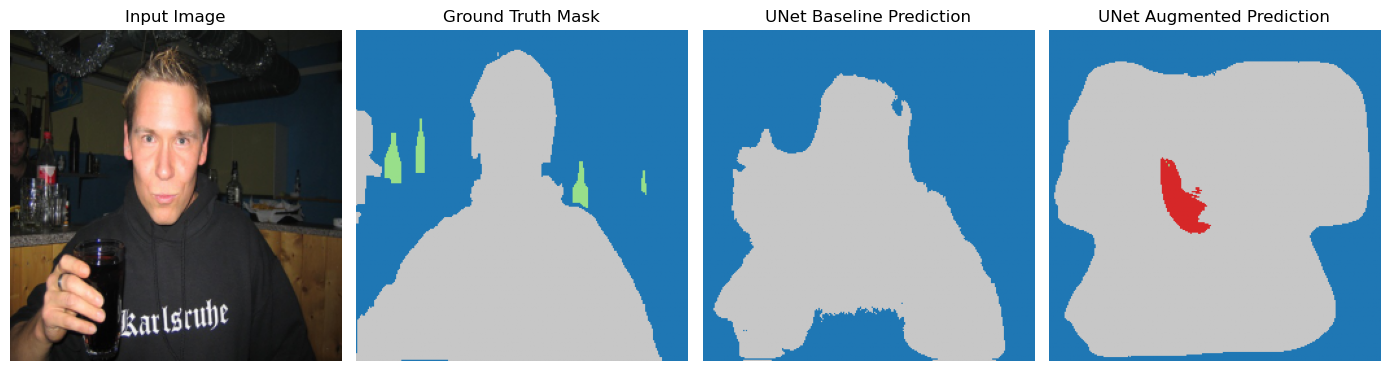

In [ ]:
pred_base = predict_mask(unet_baseline, img)
pred_aug  = predict_mask(unet_aug, img)

show_img_gt_pred_aug(img, mask, pred_base, pred_aug)


### Ablation 2: ResNet encoders

#### encoder backbone: resnet18

In [ ]:
# encoder backbone: resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
criterion_dice = DiceLoss(num_classes=NUM_CLASSES)

def criterion(pred, target):
    ce   = criterion_ce(pred, target)
    dice = criterion_dice(pred, target)
    return ce + 0.02 * dice

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
num_epochs = 20
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_resnet18_unet.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = "🌟 (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n⏱️ Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

Epoch [1/20] | Train Loss: 3.1243 | Val Loss: 3.3718 | Val mIoU: 0.0225 | Val mDice: 0.0391 | Time: 3.0s 🌟 (best so far, model saved)
Epoch [2/20] | Train Loss: 2.5262 | Val Loss: 2.3933 | Val mIoU: 0.0629 | Val mDice: 0.0953 | Time: 2.5s 🌟 (best so far, model saved)
Epoch [3/20] | Train Loss: 2.1099 | Val Loss: 2.1216 | Val mIoU: 0.0772 | Val mDice: 0.1124 | Time: 2.6s 🌟 (best so far, model saved)
Epoch [4/20] | Train Loss: 1.7644 | Val Loss: 1.8253 | Val mIoU: 0.0979 | Val mDice: 0.1306 | Time: 2.4s 🌟 (best so far, model saved)
Epoch [5/20] | Train Loss: 1.5009 | Val Loss: 1.6153 | Val mIoU: 0.0989 | Val mDice: 0.1297 | Time: 2.4s 🌟 (best so far, model saved)
Epoch [6/20] | Train Loss: 1.2854 | Val Loss: 1.4257 | Val mIoU: 0.0922 | Val mDice: 0.1215 | Time: 2.3s 
Epoch [7/20] | Train Loss: 1.1232 | Val Loss: 1.3557 | Val mIoU: 0.1000 | Val mDice: 0.1310 | Time: 2.3s 🌟 (best so far, model saved)
Epoch [8/20] | Train Loss: 0.9961 | Val Loss: 1.2705 | Val mIoU: 0.0863 | Val mDice: 0.111

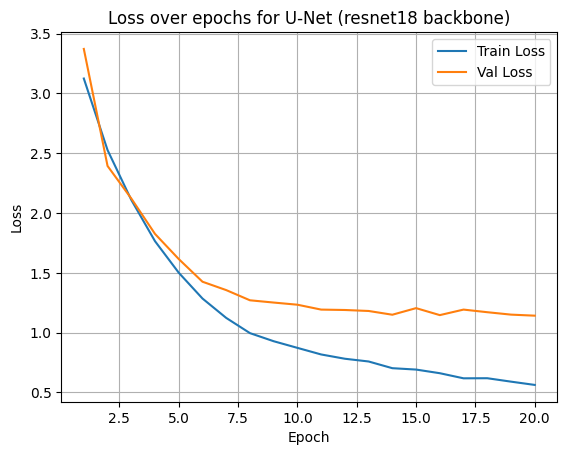

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for U-Net (resnet18 backbone)")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_resnet18_unet.png")
plt.show()

In [ ]:
best_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()


final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n U-Net (resnet18 backbone) Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )


 U-Net (resnet18 backbone) Results:
Val Loss       : 0.8640
Pixel Accuracy : 0.7945
Mean IoU       : 0.0972
Mean Dice      : 0.1314
Mean HD95      : 56.8749

Per-class IoU and Accuracy:
 0 background   | IoU: 0.8474 | Acc: 0.9777
 1 aeroplane    | IoU: 0.0000 | Acc: 0.0000
 2 bicycle      | IoU: 0.0000 | Acc: 0.0000
 3 bird         | IoU: 0.0015 | Acc: 0.0015
 4 boat         | IoU: 0.0000 | Acc: 0.0000
 5 bottle       | IoU: 0.0002 | Acc: 0.0002
 6 bus          | IoU: 0.2742 | Acc: 0.5883
 7 car          | IoU: 0.0248 | Acc: 0.0317
 8 cat          | IoU: 0.2700 | Acc: 0.3837
 9 chair        | IoU: 0.0276 | Acc: 0.0306
10 cow          | IoU: 0.0023 | Acc: 0.0023
11 diningtable  | IoU: 0.0006 | Acc: 0.0006
12 dog          | IoU: 0.0429 | Acc: 0.0740
13 horse        | IoU: 0.0337 | Acc: 0.0360
14 motorbike    | IoU: 0.0218 | Acc: 0.0226
15 person       | IoU: 0.4740 | Acc: 0.8698
16 pottedplant  | IoU: 0.0000 | Acc: 0.0000
17 sheep        | IoU: 0.0000 | Acc: 0.0000
18 sofa         | IoU

#### encoder backbone: resnet50

In [ ]:
# encoder backbone: resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
criterion_dice = DiceLoss(num_classes=NUM_CLASSES)

def criterion(pred, target):
    ce   = criterion_ce(pred, target)
    dice = criterion_dice(pred, target)
    return ce + 0.01 * dice   # ★ 关键修改：0.05 更稳定

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 按验证集 mIoU 调整学习率
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

In [ ]:
num_epochs = 20
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_resnet50_unet.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = "🌟 (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n⏱️ Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

Epoch [1/20] | Train Loss: 3.0476 | Val Loss: 3.5626 | Val mIoU: 0.0518 | Val mDice: 0.0749 | Time: 4.0s 🌟 (best so far, model saved)
Epoch [2/20] | Train Loss: 2.4173 | Val Loss: 2.5515 | Val mIoU: 0.0652 | Val mDice: 0.0872 | Time: 3.8s 🌟 (best so far, model saved)
Epoch [3/20] | Train Loss: 2.0553 | Val Loss: 2.2117 | Val mIoU: 0.0760 | Val mDice: 0.0974 | Time: 3.7s 🌟 (best so far, model saved)
Epoch [4/20] | Train Loss: 1.7146 | Val Loss: 1.8009 | Val mIoU: 0.0785 | Val mDice: 0.1022 | Time: 3.7s 🌟 (best so far, model saved)
Epoch [5/20] | Train Loss: 1.5022 | Val Loss: 1.6892 | Val mIoU: 0.0808 | Val mDice: 0.1068 | Time: 3.6s 🌟 (best so far, model saved)
Epoch [6/20] | Train Loss: 1.3360 | Val Loss: 1.4655 | Val mIoU: 0.0888 | Val mDice: 0.1130 | Time: 3.6s 🌟 (best so far, model saved)
Epoch [7/20] | Train Loss: 1.2012 | Val Loss: 1.3780 | Val mIoU: 0.0902 | Val mDice: 0.1196 | Time: 3.7s 🌟 (best so far, model saved)
Epoch [8/20] | Train Loss: 1.0585 | Val Loss: 1.3209 | Val mIo

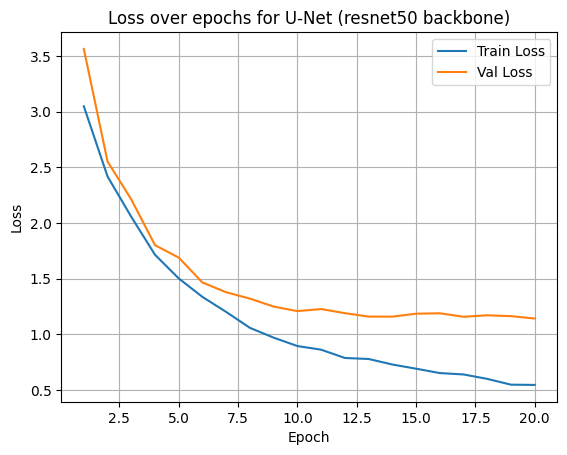

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for U-Net (resnet50 backbone)")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_resnet50_unet.png")
plt.show()

In [ ]:
best_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n U-Net (resnet50 backbone) Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )


 U-Net (resnet50 backbone) Results:
Val Loss       : 0.8469
Pixel Accuracy : 0.8097
Mean IoU       : 0.1414
Mean Dice      : 0.1952
Mean HD95      : 49.5879

Per-class IoU and Accuracy:
 0 background   | IoU: 0.8724 | Acc: 0.9685
 1 aeroplane    | IoU: 0.0001 | Acc: 0.0001
 2 bicycle      | IoU: 0.0000 | Acc: 0.0000
 3 bird         | IoU: 0.0016 | Acc: 0.0016
 4 boat         | IoU: 0.0001 | Acc: 0.0001
 5 bottle       | IoU: 0.0004 | Acc: 0.0004
 6 bus          | IoU: 0.0452 | Acc: 0.0647
 7 car          | IoU: 0.0128 | Acc: 0.0134
 8 cat          | IoU: 0.5167 | Acc: 0.9193
 9 chair        | IoU: 0.0000 | Acc: 0.0000
10 cow          | IoU: 0.0013 | Acc: 0.0013
11 diningtable  | IoU: 0.1445 | Acc: 0.2465
12 dog          | IoU: 0.0719 | Acc: 0.0877
13 horse        | IoU: 0.1876 | Acc: 0.2083
14 motorbike    | IoU: 0.2817 | Acc: 0.4791
15 person       | IoU: 0.5136 | Acc: 0.8862
16 pottedplant  | IoU: 0.0000 | Acc: 0.0000
17 sheep        | IoU: 0.0000 | Acc: 0.0000
18 sofa         | IoU

In [ ]:
def show_img_gt_pred_resnet(img, mask, pred_base, pred_res18, pred_res50):
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy().copy()
    pred_base_np = pred_base.copy()
    pred_res18_np = pred_res18.copy()
    pred_res50_np = pred_res50.copy()

    # clean ignore index (=255)
    mask_np[mask_np > 20] = 0
    pred_base_np[pred_base_np > 20] = 0
    pred_res18_np[pred_res18_np > 20] = 0
    pred_res50_np[pred_res50_np > 20] = 0

    plt.figure(figsize=(14, 10))

    # 1. Input image
    plt.subplot(1, 5, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    # 2. Ground truth
    plt.subplot(1, 5, 2)
    plt.imshow(mask_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # 3. Baseline UNet
    plt.subplot(1, 5, 3)
    plt.imshow(pred_base_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("UNet Baseline Prediction")
    plt.axis("off")

    # 4. Resnet18 UNet
    plt.subplot(1, 5, 4)
    plt.imshow(pred_res18_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("Resnet18 UNet Prediction")
    plt.axis("off")

    # 5. Resnet50 UNet
    plt.subplot(1, 5, 5)
    plt.imshow(pred_res50_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("Resnet50 UNet Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/unet_map_resnet_comparison.png")
    plt.show()

In [ ]:
# Baseline UNet
unet_baseline = UNet(num_classes=NUM_CLASSES)
unet_baseline.load_state_dict(torch.load(f"{save_dir}/best_unet_baseline.pth", map_location=device))
unet_baseline.eval()

# Resnet18 UNet
unet_base = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)
unet_base.load_state_dict(torch.load(f"{save_dir}/best_resnet18_unet.pth", map_location=device))
unet_base.eval()

# Resnet50 UNet
unet_res50 = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)
unet_res50.load_state_dict(torch.load(f"{save_dir}/best_resnet50_unet.pth", map_location=device))
unet_res50.eval()

print("✓ All models loaded!")


✓ All models loaded!


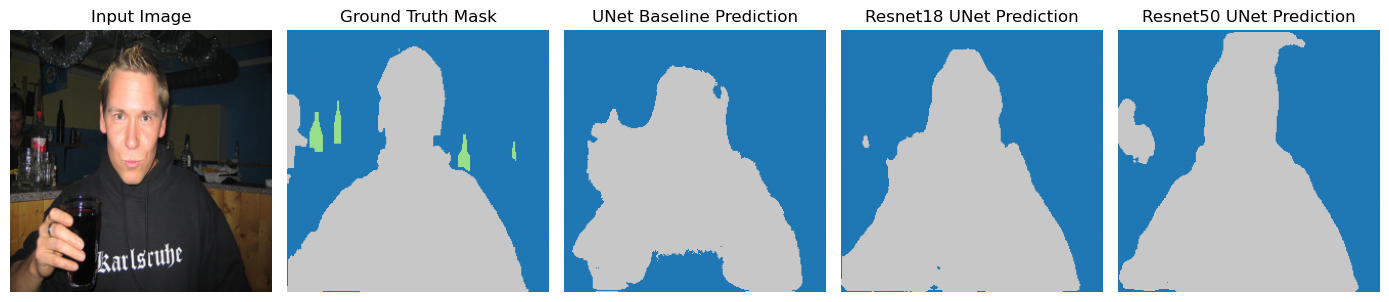

In [ ]:
pred_base = predict_mask(unet_baseline, img)
pred_res18  = predict_mask(unet_base, img)
pred_res50  = predict_mask(unet_res50, img)
show_img_gt_pred_resnet(img, mask, pred_base, pred_res18, pred_res50)

### Ablation 3: CE Only

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

Using device: cuda


In [ ]:
num_epochs = 30
best_mIoU = 0.0
best_model_path = f"{save_dir}/best_unet_ce.pth"
torch.save(model.state_dict(), best_model_path)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
}

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_metrics = evaluate(model, train_val_loader, criterion, device, NUM_CLASSES)
    val_loss = val_metrics["val_loss"]
    mIoU = val_metrics["mean_iou"]
    mDice = val_metrics["mean_dice"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mean_iou"].append(mIoU)
    history["val_mean_dice"].append(mDice)

    scheduler.step(mIoU)

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save(model.state_dict(), best_model_path)
        best_flag = " (best so far, model saved)"
    else:
        best_flag = ""

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Val mIoU: {mIoU:.4f} | Val mDice: {mDice:.4f} | "
        f"Time: {epoch_time:.1f}s {best_flag}"
    )

total_time = time.time() - start_time
print(f"\n Total training time: {total_time/60:.1f} minutes")
print(f"Best Val mIoU: {best_mIoU:.4f}, saved to {best_model_path}")

Epoch [1/30] | Train Loss: 2.6117 | Val Loss: 2.2605 | Val mIoU: 0.0378 | Val mDice: 0.0462 | Time: 2.7s  (best so far, model saved)
Epoch [2/30] | Train Loss: 2.2169 | Val Loss: 2.3594 | Val mIoU: 0.0431 | Val mDice: 0.0553 | Time: 2.2s  (best so far, model saved)
Epoch [3/30] | Train Loss: 2.0359 | Val Loss: 2.3156 | Val mIoU: 0.0417 | Val mDice: 0.0535 | Time: 2.0s 
Epoch [4/30] | Train Loss: 1.9216 | Val Loss: 2.0769 | Val mIoU: 0.0455 | Val mDice: 0.0579 | Time: 2.1s  (best so far, model saved)
Epoch [5/30] | Train Loss: 1.7981 | Val Loss: 2.0304 | Val mIoU: 0.0432 | Val mDice: 0.0547 | Time: 2.0s 
Epoch [6/30] | Train Loss: 1.7246 | Val Loss: 2.0199 | Val mIoU: 0.0370 | Val mDice: 0.0508 | Time: 2.0s 
Epoch [7/30] | Train Loss: 1.6399 | Val Loss: 1.8660 | Val mIoU: 0.0447 | Val mDice: 0.0570 | Time: 1.9s 
Epoch [8/30] | Train Loss: 1.5614 | Val Loss: 1.7808 | Val mIoU: 0.0410 | Val mDice: 0.0538 | Time: 3.0s 
Epoch [9/30] | Train Loss: 1.5248 | Val Loss: 1.7316 | Val mIoU: 0.0441

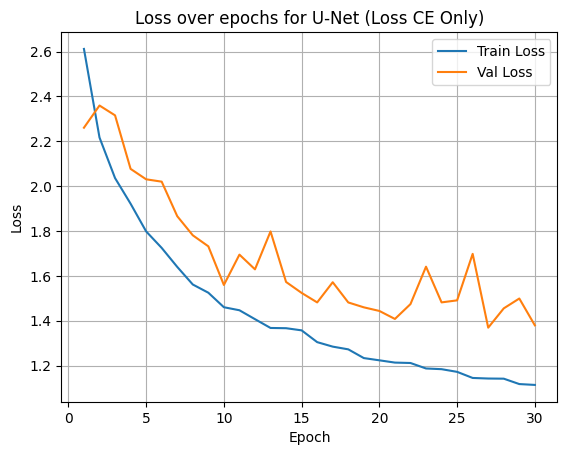

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs for U-Net (Loss CE Only)")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_unet_ce.png")
plt.show()

In [ ]:
best_model = UNet(num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

final_metrics = evaluate(best_model, test_loader, criterion, device, NUM_CLASSES)
print("\n U-Net (Loss CE Only) Results:")
print(f"Val Loss       : {final_metrics['val_loss']:.4f}")
print(f"Pixel Accuracy : {final_metrics['pixel_acc']:.4f}")
print(f"Mean IoU       : {final_metrics['mean_iou']:.4f}")
print(f"Mean Dice      : {final_metrics['mean_dice']:.4f}")
print(f"Mean HD95      : {final_metrics['hd95']:.4f}")

per_class_iou = final_metrics["per_class_iou"]
per_class_acc = final_metrics["per_class_acc"]

print("\nPer-class IoU and Accuracy:")
for idx, cls_name in enumerate(VOC_CLASSES):
    print(
        f"{idx:2d} {cls_name:12s} | "
        f"IoU: {per_class_iou[idx]:.4f} | "
        f"Acc: {per_class_acc[idx]:.4f}"
    )


 U-Net (Loss CE Only) Results:
Val Loss       : 1.3198
Pixel Accuracy : 0.7224
Mean IoU       : 0.0458
Mean Dice      : 0.0575
Mean HD95      : 105.1922

Per-class IoU and Accuracy:
 0 background   | IoU: 0.7552 | Acc: 0.9353
 1 aeroplane    | IoU: 0.0000 | Acc: 0.0000
 2 bicycle      | IoU: 0.0000 | Acc: 0.0000
 3 bird         | IoU: 0.0000 | Acc: 0.0000
 4 boat         | IoU: 0.0000 | Acc: 0.0000
 5 bottle       | IoU: 0.0000 | Acc: 0.0000
 6 bus          | IoU: 0.0000 | Acc: 0.0000
 7 car          | IoU: 0.0000 | Acc: 0.0000
 8 cat          | IoU: 0.0000 | Acc: 0.0000
 9 chair        | IoU: 0.0000 | Acc: 0.0000
10 cow          | IoU: 0.0000 | Acc: 0.0000
11 diningtable  | IoU: 0.0028 | Acc: 0.0029
12 dog          | IoU: 0.0000 | Acc: 0.0000
13 horse        | IoU: 0.0000 | Acc: 0.0000
14 motorbike    | IoU: 0.0041 | Acc: 0.0042
15 person       | IoU: 0.1994 | Acc: 0.5364
16 pottedplant  | IoU: 0.0000 | Acc: 0.0000
17 sheep        | IoU: 0.0000 | Acc: 0.0000
18 sofa         | IoU: 0.

In [22]:
def show_img_gt_pred_ce(img, mask, pred_base, pred_aug):
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy().copy()
    pred_base_np = pred_base.copy()
    pred_aug_np = pred_aug.copy()

    # clean ignore index (=255)
    mask_np[mask_np > 20] = 0
    pred_base_np[pred_base_np > 20] = 0
    pred_aug_np[pred_aug_np > 20] = 0

    plt.figure(figsize=(14, 10))

    # 1. Input image
    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    # 2. Ground truth
    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # 3. Baseline UNet
    plt.subplot(1, 4, 3)
    plt.imshow(pred_base_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("UNet Baseline Prediction")
    plt.axis("off")

    # 4. UNet CE Only
    plt.subplot(1, 4, 4)
    plt.imshow(pred_aug_np, cmap="tab20", vmin=0, vmax=20)
    plt.title("UNet (Loss CE Only) Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/unet_map_base_ce.png")
    plt.show()

In [23]:
# Baseline UNet
unet_baseline = UNet(num_classes=NUM_CLASSES)
unet_baseline.load_state_dict(torch.load(f"{save_dir}/outputs/best_unet_baseline.pth", map_location="cpu"))
unet_baseline.eval()

# UNet CE Only
unet_ce = UNet(num_classes=NUM_CLASSES)
unet_ce.load_state_dict(torch.load(f"{save_dir}/outputs/best_unet_ce.pth", map_location="cpu"))
unet_ce.eval()

print("✓ Both models loaded!")


✓ Both models loaded!


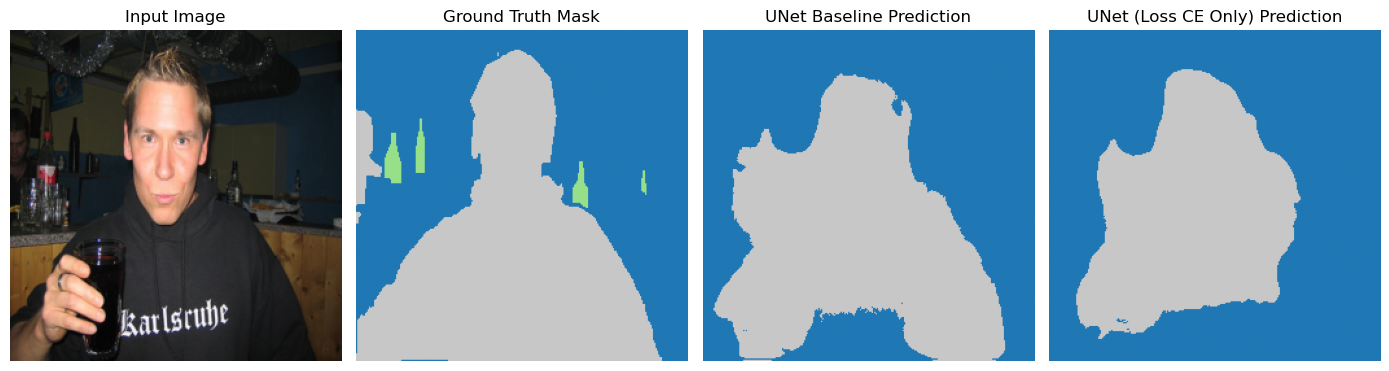

In [27]:
pred_base = predict_mask(unet_baseline, img)
pred_ce  = predict_mask(unet_ce, img)

show_img_gt_pred_ce(img, mask, pred_base, pred_ce)

### Visualization - Top3 Best & Worst

In [28]:
# Visualization
def get_predictions(model, loader, device):
    """
    Return:
        results = [
            {
                'image': (H,W,3) numpy,
                'gt': (H,W) numpy,
                'pred': (H,W) numpy
            },
            ...
        ]
    """
    model.eval()
    results = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            preds = model(images).argmax(dim=1).cpu()

            for i in range(len(images)):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                gt_np  = masks[i].squeeze().numpy()
                pred_np = preds[i].numpy()

                results.append({
                    "image": img_np,
                    "gt": gt_np,
                    "pred": pred_np
                })

    return results

def compute_person_iou(gt, pred, class_id=15):
    """
    Compute IoU for the 'person' class only.
    """
    gt_mask = (gt == class_id)
    pred_mask = (pred == class_id)

    intersection = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()

    if union == 0:
        return 0.0
    return intersection / union

def rank_images_by_person(results):
    """
    results: list from get_predictions()
    """
    scores = []

    for idx, item in enumerate(results):
        iou = compute_person_iou(item["gt"], item["pred"])
        scores.append((idx, iou))

    scores.sort(key=lambda x: x[1], reverse=True)

    best3 = scores[:3]
    worst3 = scores[-3:]

    return best3, worst3

In [ ]:
def show_mosaic(results, indices, title):
    rows = len(indices)

    fig, axes = plt.subplots(
        rows, 3,
        figsize=(14, 4 * rows)
    )

    if rows == 1:
        axes = axes.reshape(1, -1)

    for r, (idx, score) in enumerate(indices):
        item = results[idx]
        img = item["image"]
        gt = item["gt"]
        pred = item["pred"]

        gt_vis = gt.copy()
        gt_vis[gt_vis > 20] = 0

        pred_vis = pred.copy()
        pred_vis[pred_vis > 20] = 0

        axes[r, 0].imshow(img)
        if r == 0:
            axes[r, 0].set_title("Image", fontsize=12)
        axes[r, 0].axis("off")

        axes[r, 1].imshow(gt_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0:
            axes[r, 1].set_title("Ground Truth", fontsize=12)
        axes[r, 1].axis("off")

        axes[r, 2].imshow(pred_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0:
            axes[r, 2].set_title("UNet Pred", fontsize=12)
        axes[r, 2].axis("off")

    plt.subplots_adjust(wspace=0, hspace=0.01)
    fig.suptitle(title, fontsize=18)
    plt.show()

Top 3 person IoUs: [(184, 0.6663091833492215), (4, 0.6582158313555773), (121, 0.6525575577267656)]
Worst 3 person IoUs: [(209, 0.0), (210, 0.0), (211, 0.0)]


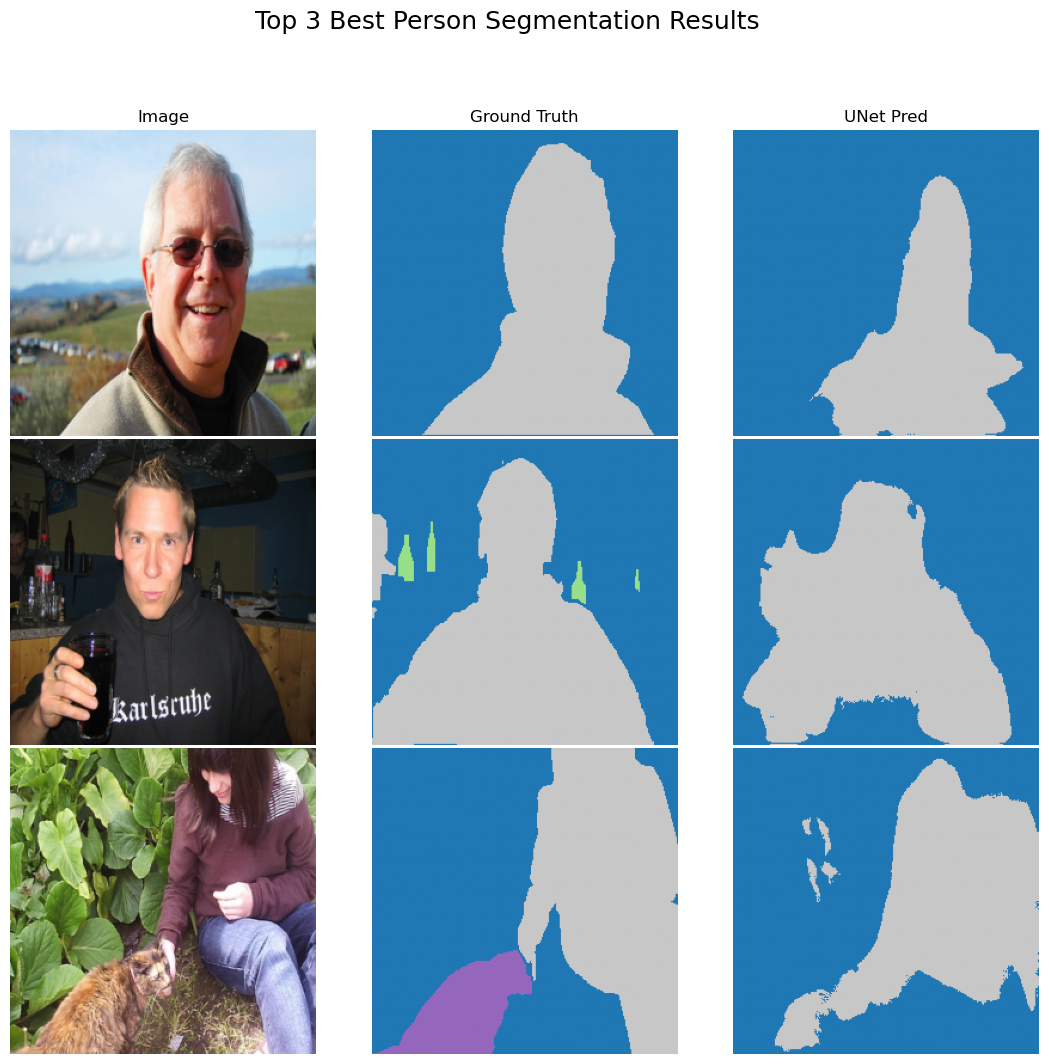

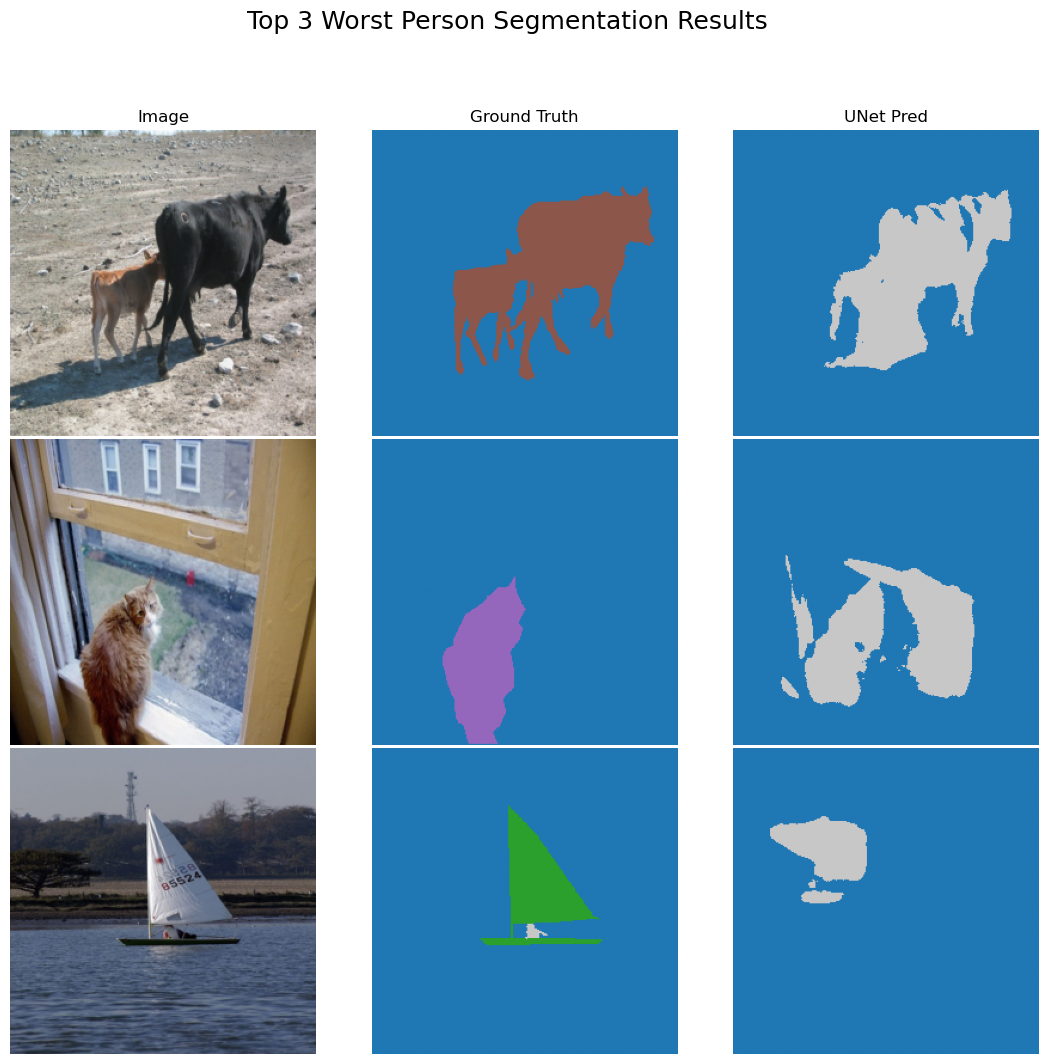

In [44]:
# get predictions for all test images
results = get_predictions(unet_baseline, test_loader, device="cpu")

# rank by IoU(person)
best3, worst3 = rank_images_by_person(results)

print("Top 3 person IoUs:", best3)
print("Worst 3 person IoUs:", worst3)

# visualize
show_mosaic(results, best3, "Top 3 Best Person Segmentation Results")
show_mosaic(results, worst3, "Top 3 Worst Person Segmentation Results")